In [1]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statistics import mean
import scipy
from pathlib import Path
import math

from radiometric.LUT import create_LUT_df, determine_reference, applyNUC_to_LUT

from NUC.NUC_functions import import_NUC, apply_NUC, get_slice, determine_slope
from NUC.NUC_functions import determine_dark, apply_DFC_to_df
from NUC.NUC_functions import pixel_registration

from NUC.ACKTAR import acktar_corr

from matplotlib import cm
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq


#  Plotting Configuration

In [46]:
#Plotting Options
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times New Roman"
import matplotlib.colors as colors

# Calibration Parameters and Filepaths

In [6]:
#choose filepath to desired data
path = 'path'
#note cam definitions are flipped as of FLIRPY ffc fix 
cal_file2 =  '/path/calibration_files/cam1pixel.h5'
cal_file1 =  '/path/calibration_files/cam2pixel.h5'

In [48]:
waves= np.linspace(7,12.5,80)

In [4]:
#location of Acktar reference region
xref1 = 25
xref2 = 75

In [49]:
#select ROI
ymin2 = 90; ymax2 = 150;
ymin1 = 120; ymax1 = 180;

FOV = 5.33 ;
HFOV = FOV/4;
angles = np.round(np.linspace(-HFOV,HFOV,ymax2-ymin2))

# Import Raw Data 

## Check Intermediate Image

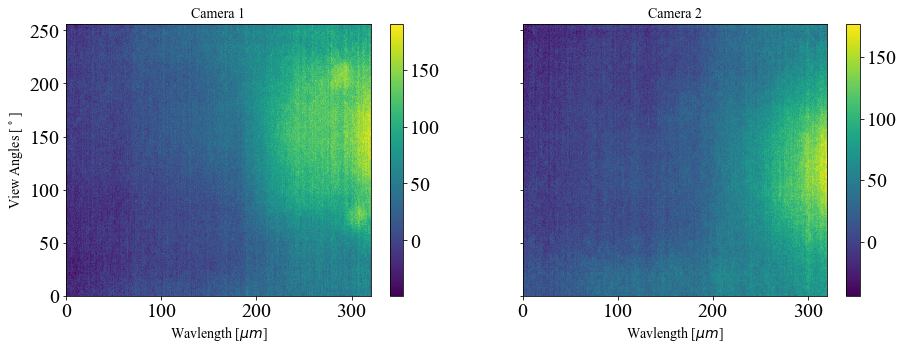

In [55]:
filename = path + 'Capture0.hdf5'


with h5py.File(filename, "r") as file:
    image1 = np.mean(file['image1'][()],axis = 0)
    image2 = np.mean(file['image2'][()],axis = 0)
    s1 = np.std(file['image1'][()],axis = 0)
    s2 = np.mean(file['image2'][()],axis = 0)
    t2 = np.mean(file['temp2'][()],axis = 0)
    t1 = np.mean(file['temp1'][()],axis = 0)

c1 = (image1-np.mean(image1[ymin1:ymax1,xref1:xref2]))

c2 = (image2-np.mean(image2[ymin2:ymax2,xref1:xref2]))


#plot test images, test appearance
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),sharey = True)

p1 = axes[0].pcolormesh(c1,shading = 'auto')#,vmin = 0)
fig.colorbar(p1, ax=axes[0])
axes[0].set_title('Camera 1',fontsize = 14)
axes[0].set_ylabel('View Angles [$^\circ$]',fontsize = 14)
axes[0].set_xlabel('Wavlength [$\mu m$]',fontsize = 14)

p2 = axes[1].pcolormesh(c2,shading = 'auto')#,vmin = 0)
axes[1].set_title('Camera 2',fontsize = 14)
axes[1].set_xlabel('Wavlength [$\mu m$]',fontsize = 14)
fig.colorbar(p2, ax=axes[1])

plt.show()

## Import Full Dataset & Apply Acktar offset

In [7]:
dataset_size = 2600
im1 = []
im2 = []
std1 = []
std2 = []

#change file naming convention depending on type of data being processed
for t in range(dataset_size):
    filename = path +'Capture'+ str(round(t))+'.hdf5'
    try:
        with h5py.File(filename, "r") as file:
            image1 = np.mean(file['image1'][()],axis = 0)
            image2 = np.mean(file['image2'][()],axis = 0)
            s1 = np.std(file['image1'][()],axis = 0)
            s2 = np.std(file['image2'][()],axis = 0)
            t2 = np.mean(file['temp2'][()],axis = 0)
            t1 = np.mean(file['temp1'][()],axis = 0)

       
        c1 = (image1-np.mean(image1[ymin1:ymax1,xref1:xref2])) - acktar_corr(t1)
        c2 = (image2-np.mean(image2[ymin2:ymax2,xref1:xref2])) - acktar_corr(t2)

        im1.append(c1)
        im2.append(c2)
        std1.append(s1)
        std2.append(s2)
    except:
        print('error')



In [57]:
#Find location of 0 degree point, center of FOV 
p2 = pixel_registration(im2[1],cal_file2,waves,0,320)
p1 = pixel_registration(im1[1],cal_file1,waves,0,320)
plt.plot(np.sum(p2,axis = 1))
plt.plot(np.sum(p1,axis = 1))
plt.show()

y1 = 142
y2 = 119

# Pixel Registration

In [59]:
responses = np.zeros([2600,len(waves)])
responses1 = np.zeros([2600,len(waves)])
responses2 = np.zeros([2600,len(waves)])
responses_err = np.zeros([2600,len(waves)])
responses_err1 = np.zeros([2600,len(waves)])
responses_err2 = np.zeros([2600,len(waves)])

for t in range(len(im1)):
    p2 = pixel_registration(im2[t],cal_file2,waves,ymin2,ymax2)
    p1 = pixel_registration(im1[t],cal_file1,waves,ymin1,ymax1)
    s2 = pixel_registration(std2[t],cal_file2,waves,ymin2,ymax2)
    s1 = pixel_registration(std1[t],cal_file1,waves,ymin1,ymax1)

    err = np.sqrt((s2[y2-ymin2])**2+(s1[y1-ymin1])**2)
    responses[t]= (p1[y1-ymin1]+p2[y2-ymin2])
    responses_err[t]= err
    
    responses1[t]= p1[y1-ymin1]
    responses_err1[t]= s1[y1-ymin1]
    responses2[t]= p2[y2-ymin2]
    responses_err2[t]= s2[y2-ymin2]


# Save Processed Data

In [60]:
hf = h5py.File(path + 'data.h5', 'w')
hf.create_dataset('/var', data=var)
hf.create_dataset('/var1', data=var)
hf.create_dataset('/var2', data=var)
hf.create_dataset('/nedt', data=nedt)

hf.create_dataset('/responses1', data=responses1)
hf.create_dataset('/responses2', data=responses2)
hf.create_dataset('/responses_err1', data=responses_err1)
hf.create_dataset('/responses_err2', data=responses_err2)

#change the names of the below variables depending on dataset type (polarization calibration, LUT calibration, field data, ect)
hf.create_dataset('/waves',data = waves)
hf.create_dataset('/angles', data = temps)

hf.close()